# Using RG with images

This notebook walks through the necessary steps to use Robustness Gym with image data. It uses the CelebA dataset as downloaded by Torchvision as an example.

## Prepare the dictionary with the image data

Robustness Gym works with images by keeping track of where they are, and the associated metadata. These two pieces of information (location of the image and associated metadata) is all that is required to create a dataset. However, this requires the user to create a list of dictionaries (one for each image). We exemplify that preprocessing step here, for the CelebA dataset (~3Gb; if you already have it on your local machine, please edit the `dataset_dir` variable).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from robustnessgym import Dataset
import torch

ModuleNotFoundError: No module named 'robustnessgym'

In [68]:
from spr.data.celeb import build_celeb_df

out = build_celeb_df(split_configs=[{"split": "train", "size": 10000}, {"split": "valid", "size": 2000}])
df = out.load()


task: build_celeb_df, run_id=5


In [3]:
from spr.data.celeb import build_celeb_df
df = build_celeb_df.out(load=True)

In [4]:
train_dataset = Dataset.load_image_dataset(
    df[df.split == "train"].to_dict('records'), 
    img_keys="img_path"
)

NameError: name 'Dataset' is not defined

In [109]:
from typing import Optional, Callable
from robustnessgym.core.dataformats.vision import RGVisionFolder, VisionDataset

class RGTrainDataset(torch.utils.data.Dataset):

    def __init__(
        self, 
        dataset: VisionDataset,
        input_key: str, 
        target_key: str,  
        id_key: str,
        transform: Optional[Callable] = None,
    ):
       self.dataset = dataset
       self.target_key = target_key
       self.input_key = input_key
       self.id_key = id_key
       self.transform = transform if transform is not None else lambda x: x
    
    def __getitem__(self, index: int):
        data = self.dataset[index]
        input_img = self.transform((data[self.input_key][:])).to(torch.float)
        target = torch.tensor(data[self.target_key], dtype=torch.long)
    
        return input_img, target, data[self.id_key]
    
    def __len__(self):
        return len(self.dataset)

In [113]:
from spr.utils import PredLogger, TerraCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl 
import torchvision.transforms as transforms


model = Classifier(model=ResNet(num_classes=2))

logger = TensorBoardLogger(
    save_dir=os.path.join(os.getcwd(), "tensorboard"), name="logs"
)
trainer = pl.Trainer(
    gpus=1,
    max_epochs=1,
    log_every_n_steps=1,
    logger=logger,
    callbacks=[],
    default_root_dir=os.getcwd(),
    accelerator=None,
)
train_dataset = Dataset.load_image_dataset(
    df[df.split == "train"].to_dict('records'), 
    img_keys="img_path"
)
valid_dataset = Dataset.load_image_dataset(
    df[df.split == "valid"].to_dict('records'), 
    img_keys="img_path"
)

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.permute(2,0,1)), # channels first
    transforms.Resize((256, 256)),
])
train_dl = torch.utils.data.DataLoader(
    RGTrainDataset(
        train_dataset, input_key="img_path", target_key="arched_eyebrows", id_key="file", transform=transform
    ),
    num_workers=3,
    batch_size=16
)
valid_dl = torch.utils.data.DataLoader(
    RGTrainDataset(
        valid_dataset, input_key="img_path", target_key="arched_eyebrows", id_key="file", transform=transform
    ),
    num_workers=3,
    batch_size=4
)
trainer.fit(model, train_dl, valid_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
[2021-04-01 19:56:43,415][INFO][robustnessgym.core.dataformats.vision:281] :: Created `VisionDataset` with 10000 rows and 45 columns.
[2021-04-01 19:56:43,420][INFO][root:340] :: Added column `index` with length `10000`.
[2021-04-01 19:56:43,516][INFO][robustnessgym.core.dataformats.vision:281] :: Created `VisionDataset` with 2000 rows and 45 columns.
[2021-04-01 19:56:43,518][INFO][root:340] :: Added column `index` with length `2000`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | model       | ResNet     | 11.2 M
1 | metrics     | ModuleDict | 0     
2 | valid_preds | PredLogger | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


AttributeError: 'tuple' object has no attribute 'cpu'

In [119]:
for x in list(model.valid_preds.children()):
    try:
        x.cpu()
    except:
        print(x)


In [116]:
model.cpu()

AttributeError: 'tuple' object has no attribute 'cpu'

In [6]:
%%time
import os
import pandas as pd
from functools import reduce
import torchvision

# Download CelebA
dataset_dir = '/dfs/scratch0/sabri/data/datasets/'
#torchvision.datasets.CelebA(root=dataset_dir, download=True)

# Get the names of the image files
filenames = os.listdir(dataset_dir+'/celeba/img_align_celeba')

# Load the metadata information
bbox = pd.read_csv(dataset_dir + "/celeba/list_bbox_celeba.txt", sep="\s+", header=1)

with open(dataset_dir + "/celeba/list_attr_celeba.txt") as f:
    f.readline() # Skip the first line
    column_names = f.readline().strip().split(" ") # Get the column names
    column_names = ["image_id"] + column_names # Append the "image_id" column
attr = pd.read_csv(
    dataset_dir + "/celeba/list_attr_celeba.txt",
    sep="\s+",
    names=column_names,
    header=1
)

evalset = pd.read_csv(dataset_dir + "/celeba/list_eval_partition.txt", sep="\s+", names=["image_id", "partition"])

with open(dataset_dir + "/celeba/list_landmarks_align_celeba.txt") as f:
    f.readline() # Skip the first line
    column_names = f.readline().strip().split(" ") # Get the column names
    column_names = ["image_id"] + column_names # Append the "image_id" column
landmarks = pd.read_csv(
    dataset_dir + "/celeba/list_landmarks_align_celeba.txt",
    sep="\s+",
    names=column_names,
    header=1
)

# Combine everything into a table
metadata = reduce(lambda x, y: pd.merge(x, y, on="image_id"), [bbox, attr, evalset, landmarks])
metadata["image_file"] = dataset_dir + '/celeba/img_align_celeba/' + metadata["image_id"]

# Convert to a list of dictionaries
rg_dataset = metadata.to_dict('records')

CPU times: user 11.8 s, sys: 4.59 s, total: 16.4 s
Wall time: 16.4 s


In [12]:
metadata.partition

0         0
1         0
2         0
3         0
4         0
         ..
202594    2
202595    2
202596    2
202597    2
202598    2
Name: partition, Length: 202599, dtype: int64

In case you want to limit the size of the dataset for the rest of the demo, run the cell below.

In [4]:
%%time
from robustnessgym import Dataset
import torch

celebA = Dataset.load_image_dataset(rg_dataset, img_keys="image_file")

[2021-03-24 09:27:47,876][INFO][root:41] :: Logging initialized.
[2021-03-24 09:28:04,294][INFO][robustnessgym.core.dataformats.vision:268] :: Created `VisionDataset` with 100 rows and 57 columns.
[2021-03-24 09:28:04,299][INFO][root:327] :: Added column `index` with length `100`.


CPU times: user 10 s, sys: 1.69 s, total: 11.7 s
Wall time: 16.4 s


In [5]:
celebA. 

RGDataset[num_rows: 100](RGDataset)

## Working with images

After the dataset has been created, we can run the standard RG operations: filters, maps, and updates.

The cell below filters images of young people with an average red level above 127.

In [6]:
%%time
out = celebA.filter(lambda x: torch.mean(1.0*x['image_file'][:,:,0]) > 127 and x["Young"] > 0, input_columns=['image_file', 'Young'], num_proc=64)

[2021-03-24 09:28:04,470][INFO][robustnessgym.core.dataformats.vision:268] :: Created `VisionDataset` with 0 rows and 0 columns.
[2021-03-24 09:28:04,487][INFO][robustnessgym.core.dataformats.vision:890] :: Running `filter`, a new dataset will be returned.
[2021-03-24 09:28:04,488][INFO][robustnessgym.core.dataformats.vision:748] :: Converting `function` <function convert_to_batch_fn.<locals>.<lambda> at 0x7f03e0afa8b0> to a batched function.
[2021-03-24 09:28:07,570][INFO][robustnessgym.core.dataformats.vision:781] :: Running `map`, the dataset will be left unchanged.


[2021-03-24 09:28:07,998][INFO][robustnessgym.core.dataformats.vision:268] :: Created `VisionDataset` with 0 rows and 0 columns.


CPU times: user 1.68 s, sys: 3.1 s, total: 4.78 s
Wall time: 3.54 s


**Caveat emptor:** The `1.0` multiplier is required because the images are loaded as integers, but `torch.mean` expects a tensor of floating point numbers.

After running the filter, we can confirm that our dataset has shrinked.

In [7]:
out

RGDataset[num_rows: 48](RGDataset)

We can use Matplotlib to render the images. Since RG only stores pointers to the images, it is necessary to let it know that the image data is being requested. This can be done by indexing the image object, as shown below.

tensor(181.0181)

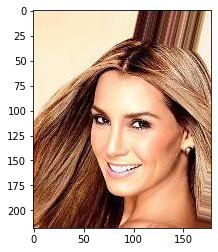

In [8]:
import matplotlib.pyplot as plt

plt.imshow(out[0]['image_file'][:]) # Note the [:]. This tells RG to return the actual image.
torch.mean(1.0*out[0]['image_file'][:,:,0]) # We can check that average red level > 127

Mapping operations are also supported. The following example rotates the images to the left 90 degrees.

In [9]:
mapped_out = celebA.map(lambda x: x['image_file'].transpose(0,1))

[2021-03-24 09:28:08,450][INFO][robustnessgym.core.dataformats.vision:748] :: Converting `function` <function convert_to_batch_fn.<locals>.<lambda> at 0x7f03e16be160> to a batched function.
[2021-03-24 09:28:11,843][INFO][robustnessgym.core.dataformats.vision:781] :: Running `map`, the dataset will be left unchanged.


Unlike the filter operation, the map operation actually loads the images, modifies them, and returns the corresponding tensors. However, this data is not cached anywhere, and will be lost once the variable gets reassigned. To cache the modified images, use the `update` function (demoed below).

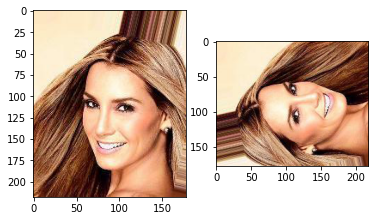

In [10]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(out[0]['image_file'][:])
ax[1].imshow(mapped_out[0]) # Notice that [:] is not required, but there would be no problem if it were used.

We can do more complex operations on the images, such as blurring them.

[2021-03-24 09:28:12,482][INFO][robustnessgym.core.dataformats.vision:748] :: Converting `function` <function convert_to_batch_fn.<locals>.<lambda> at 0x7f03dd964ca0> to a batched function.
[2021-03-24 09:28:15,678][INFO][robustnessgym.core.dataformats.vision:781] :: Running `map`, the dataset will be left unchanged.



CPU times: user 6.74 s, sys: 3.36 s, total: 10.1 s
Wall time: 3.81 s


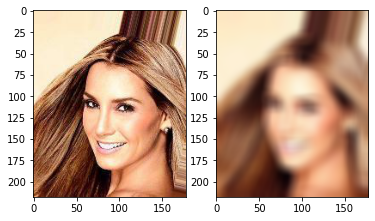

In [11]:
%%time
import torchvision

blur = torchvision.transforms.GaussianBlur(15, (1,10))
blurred = celebA.map(lambda x: blur(x['image_file'].permute(2,0,1)).permute(1,2,0))

fig, ax = plt.subplots(1,2)
ax[0].imshow(out[0]['image_file'][:])
ax[1].imshow(blurred[0])

As a final example of `map`, the following cell converts the images to greyscale.

[2021-03-24 09:28:16,541][INFO][robustnessgym.core.dataformats.vision:748] :: Converting `function` <function convert_to_batch_fn.<locals>.<lambda> at 0x7f03dcdc0040> to a batched function.
[2021-03-24 09:28:19,881][INFO][robustnessgym.core.dataformats.vision:781] :: Running `map`, the dataset will be left unchanged.


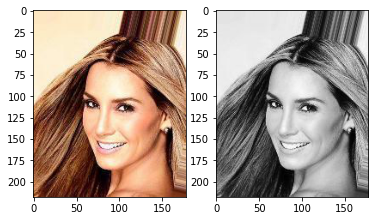

In [12]:
grey = celebA.map(lambda x: torch.mean(1.0*x['image_file'], dim=2))

fig, ax = plt.subplots(1,2)
ax[0].imshow(out[0]['image_file'][:])
ax[1].imshow(grey[0], cmap="gray")

We may want to keep the greyscale images, and run more tests on them. Using function `update`, we can get a new Dataset object with a new column containing the greyscale images. This function will modify and save the images to the default system temporary directory. You may specify where you want the images saved using argument `cache_dir`.

In [13]:
%%time
celebA_greyscale = celebA.update(lambda example: {'grey_images': torch.mean(1.0*example['image_file'], dim=2)}, cache_dir='/lfs/1/jparaujo/datasets/vision/wilds/celebA_cache')

[2021-03-24 09:28:20,521][INFO][robustnessgym.core.dataformats.vision:268] :: Created `VisionDataset` with 0 rows and 0 columns.
[2021-03-24 09:28:20,524][INFO][robustnessgym.core.dataformats.vision:555] :: Converting `function` <function convert_to_batch_fn.<locals>.<lambda> at 0x7f03ddd35b80> to batched function.
[2021-03-24 09:28:20,525][INFO][robustnessgym.core.dataformats.vision:581] :: Running update, a new dataset will be returned.
[2021-03-24 09:28:20,525][INFO][robustnessgym.core.dataformats.vision:268] :: Created `VisionDataset` with 0 rows and 0 columns.
[2021-03-24 09:28:23,870][INFO][robustnessgym.core.dataformats.vision:781] :: Running `map`, the dataset will be left unchanged.


[2021-03-24 09:28:48,261][INFO][root:327] :: Added column `grey_images` with length `100`.


CPU times: user 1.95 s, sys: 6.84 s, total: 8.79 s
Wall time: 27.7 s


We may also want to compute some statistic on the images, and save them as a new column. The following example adds a column with the average red level of each image.

In [14]:
%%time
celebA_greyscale = celebA_greyscale.update(lambda example: {'avg_red': torch.mean(1.0*example['image_file'][:,:,0])})

[2021-03-24 09:28:48,268][INFO][robustnessgym.core.dataformats.vision:268] :: Created `VisionDataset` with 0 rows and 0 columns.
[2021-03-24 09:28:48,273][INFO][robustnessgym.core.dataformats.vision:555] :: Converting `function` <function convert_to_batch_fn.<locals>.<lambda> at 0x7f03ddd35b80> to batched function.
[2021-03-24 09:28:48,274][INFO][robustnessgym.core.dataformats.vision:581] :: Running update, a new dataset will be returned.
[2021-03-24 09:28:48,275][INFO][robustnessgym.core.dataformats.vision:268] :: Created `VisionDataset` with 0 rows and 0 columns.
[2021-03-24 09:28:55,080][INFO][robustnessgym.core.dataformats.vision:781] :: Running `map`, the dataset will be left unchanged.


[2021-03-24 09:28:56,184][INFO][root:327] :: Added column `avg_red` with length `100`.


CPU times: user 9.71 s, sys: 6.78 s, total: 16.5 s
Wall time: 7.92 s


Finally, we can also compute statistics on the greyscale images.

In [15]:
%%time
celebA_greyscale = celebA_greyscale.update(lambda example: {'avg_level': torch.mean(1.0*example['grey_images'][:,:,0])})

[2021-03-24 09:28:56,192][INFO][robustnessgym.core.dataformats.vision:268] :: Created `VisionDataset` with 0 rows and 0 columns.
[2021-03-24 09:28:56,223][INFO][robustnessgym.core.dataformats.vision:555] :: Converting `function` <function convert_to_batch_fn.<locals>.<lambda> at 0x7f03dbc71310> to batched function.
[2021-03-24 09:28:56,223][INFO][robustnessgym.core.dataformats.vision:581] :: Running update, a new dataset will be returned.
[2021-03-24 09:28:56,224][INFO][robustnessgym.core.dataformats.vision:268] :: Created `VisionDataset` with 0 rows and 0 columns.
[2021-03-24 09:29:02,896][INFO][robustnessgym.core.dataformats.vision:781] :: Running `map`, the dataset will be left unchanged.


[2021-03-24 09:29:03,637][INFO][root:327] :: Added column `avg_level` with length `100`.


CPU times: user 2.62 s, sys: 6.67 s, total: 9.28 s
Wall time: 7.45 s


## Select a subpopulation

In RG, we are interested in evaluating how models perform on different subpopulations of the data. Creating subpopulations of images is as straighforward as with other types of data. First, create the subpopulation filter that interests you. In this example, we want the images with the lowest and highest red levels.

In [16]:
from robustnessgym import ScoreSubpopulation, Identifier

sp = ScoreSubpopulation(
    intervals=[('0%', '5%'), ('95%', '100%')],
    identifiers=[Identifier('Red-Low'), Identifier('Red-High')],
    score_fn=lambda batch, columns: [e for e in batch[columns[0]]],
)

out = sp(celebA_greyscale, ['avg_red'])

After the subpopulation filter has finished running we can plot the images from each group.

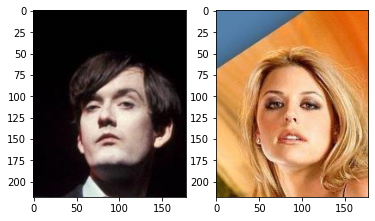

In [17]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(out[0][0][0]['image_file'][:])
ax[1].imshow(out[0][1][0]['image_file'][:])

In the example above we leveraged the `avg_red` column that we had added previously. We could have computed that data on the fly, as the next example shows.

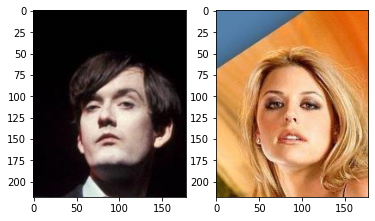

In [18]:
sp = ScoreSubpopulation(
    intervals=[('0%', '5%'), ('95%', '100%')],
    identifiers=[Identifier('Red-Low'), Identifier('Red-High')],
    score_fn=lambda batch, columns: [torch.mean(1.0*img[:,:,0]) for img in batch[columns[0]]],
)

out = sp(celebA_greyscale, ['image_file'])

fig, ax = plt.subplots(1,2)
ax[0].imshow(out[0][0][0]['image_file'][:])
ax[1].imshow(out[0][1][0]['image_file'][:])

We can do the same filtering on the greyscale images. We will use the `avg_level` column that we added previously.

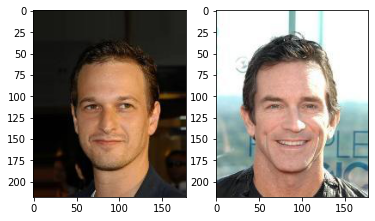

In [19]:
sp = ScoreSubpopulation(
    intervals=[('0%', '5%'), ('95%', '100%')],
    identifiers=[Identifier('Level-Low'), Identifier('Level-High')],
    score_fn=lambda batch, columns: [e for e in batch[columns[0]]],
)

out = sp(celebA_greyscale, ['avg_level'])

fig, ax = plt.subplots(1,2)
ax[0].imshow(out[0][0][0]['image_file'][:])
ax[1].imshow(out[0][1][0]['image_file'][:])

Finally, we can also plot the transformed images (cached locally).

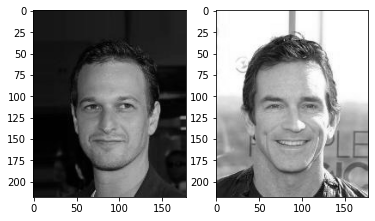

In [20]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(out[0][0][0]['grey_images'][:])
ax[1].imshow(out[0][1][0]['grey_images'][:])